In this tutorial, we would like to implement VALMOD algorithm proposed in paper [VALMOD](https://arxiv.org/pdf/2008.13447.pdf), and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [280]:
%matplotlib inline

import stumpy
from stumpy import core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import heapq

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

**Notation:** $T_{i,m} = T[i:i+m]$, a subsequence of `T` that starts at index `i` and has length `m`. 

## Motif discovery

For a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$, Motif set $S^{m}_{r}$ is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

We would like to find set $S^{*} = \bigcup\limits_{m=min\_m}^{max\_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty because both these two subsequences start from the same index.

## Discord Discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: For the subsequence $T_{i,m}$, its $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequence and its ($n^{th}$ ?) best match. <br>

**NOTE**:<br>
Why should we care about $n^{th}$ discord (n>1)? We provide a simple example below:

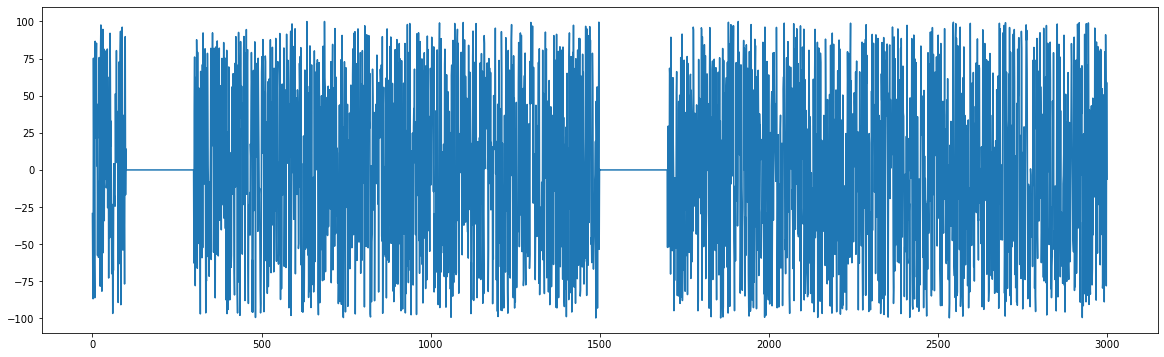

In [2]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0 for them. Therefore, we may need to investigate other neighbors rather than just 1NN. In discord discovery, it is called twin-freak problem (see [Tutorial](https://cci.drexel.edu/bigdata/bigdata2017/files/Tutorial4.pdf)). It happens when the (same) anomally occurs more than once. In our example above, the anomaly occurs twice. Therefore, we should be able to detect it if we consider 2nd nearest neighbor. 

For further details, see Fig. 2 of the paper. Notice that `Top-1 2nd discord` subsequence has a close 1-NN; however, it is far from its 2nd closest neighbor.)

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`,`K`, and `N`, we want to find **top-k $n^{th}$ discord** for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2-Lower Bound of Distance Profile

Lower Bound (LB) for $d(T_{j,m+k}, T_{i,m+k})$ can be calculated as follows:

**Non-normalized distance (p-norm):**


$$
\begin{align}
LB_{j,i}^{(m+k)} ={}& 
d_{j,i}^{(m)} \quad (1)
\end{align}
$$


**Normalized distance (see eq(2) of the paper):**


$$
\begin{align}
  LB={}& 
  \begin{cases}
    \frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{
m\left(
1 - \rho^{(m)^{2}}_{j,i}
\right)
}, & \text{if $\rho^{m}_{j,i}>0$}\\
    \frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{
m
}, & \text{otherwise}
  \end{cases}
\end{align}
$$


Or, equivalently:

$$
\begin{align}
LB_{j,i}^{(m+k)} ={}& 
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{
m\left(
1 - \max(\rho^{(m)}_{j,i},0)^{2}
\right)
} \quad (2)
\\
\end{align}
$$


And, the pearson correlation $\rho^{(m)}_{j,i}$ can be calculated as follows: 


$$
\begin{align}
\rho^{(m)}_{j,i} ={}& 
\frac{\sum \limits_{t=0}^{m-1}{T[i+t]T[j+t]} - m\mu_{i,m}\mu_{j,m}}{m\sigma_{i,m}\sigma_{j,m}} \quad (2a)
\end{align} 
$$


Alternatively, $\rho^{(m)}_{j,i}$ and $d^{(m)}_{j,i}$ are related to each other according to the following formula:


$$
\begin{align}
d^{(m)}_{j,i} ={}& 
\sqrt{
2m \left(
1-\rho^{(m)}_{j,i}
\right)
} \quad {(2b)}
\\
\end{align}
$$


# 3- Core Idea

The core idea of VALMOD can be explained as follows:

## 3-1: Ranked Lower Bound (LB) of Distance Profile 
Ranked LB of distance profile refers to the values of the LB of a distance profile sorted in the ascending order. It is important to note that such ranking is preserved for all subsequence length range `(min_m+1, max_m)` having assumed that they are all being calculated based on the distance profile for subsquence with length `min_m`.

In other words,<br>
**IF:**


$$
\begin{align}
LB^{(m+k_{1})}_{j,i} \leq{}& 
LB^{(m+k_{1})}_{j,i^{'}}
\\
\end{align}
$$


**THEN:**


$$
\begin{align}
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
LB^{(m+k_{1})}_{j,i} 
\leq{}&
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
LB^{(m+k_{1})}_{j,i'}
\\
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
\left[
\frac{\sigma_{j,m}}{\sigma_{j,m+k_{1}}}
\sqrt{
m\left(
1 - \max(\rho^{(m)}_{j,i},0)^{2}
\right)
}
\right]
\leq{}&
\frac{
\sigma_{j,m+k_{1}}}
{\sigma_{j,m+k_{2}}
}
\left[
\frac{\sigma_{j,m}}{\sigma_{j,m+k_{1}}}
\sqrt{
m\left(
1 - \max(\rho^{(m)}_{j,i'},0)^{2}
\right)
}
\right]
\\
LB^{(m+k_{2})}_{j,i} \leq{}& 
LB^{(m+k_{2})}_{j,i'}
\\
\end{align}
$$


## 3-2: Accelerating Matrix Profile calculation
Storing all "ranked LB" for all indices requires a significant amount of memory. Instead, we can just store the `top-p` smallest values of the ranked $LB^{(m+k)}_{j}$ and their corresponding indices. The parameter `p` is set by the user (e.g. see Table 2 on page 28). As we will see in the next section, we can use this meta information to skip some unnecessary calculation of distances for length larger than `min_m`.

# 4-VALMOD algorithm
The VALMOP algorithm (see Algorithm1 and Algorithm2 on page 13) discovers variable-length matrix profile and the matrix profile indices. In this section, we implement the functions by taking a bottom-top approach. So, we first implement the functions that are being called by VALMOD algorithm, and then we implement VALMOD algorithm.

## 4-1- ComputeMatrixProfile (see Algorith3 on page 15)
This algorithm scans all pairs of subsequences. However, instead of just returning the matrix profile and its indices, the algorithm returns the `top-p` smallest value of each distance profile and their indices as well.

In the paper, the authors used the LB formula to convert distances to LB. So, as they scan pairs of subsequences,  they calculate LB for each pair of subsequences. The authors used heap data structure to store `top-p` smallest LB values for each distance profile. 

**NOTE (1): Our implementation is slightly different than what proposed in the Algorithm3 of the paper**
We can skip line19 of Algorithm 3 provided in the paper. We do NOT need to calculate $LB^{(m+k)}_{j,i}$ corresponding to each $d^{(m)}_{j,i}$. As we prove below, the ranked distance profile, $DP^{(m)}_{j}$, is in the same order as its corresponding ranked Lower Bound, $LB^{(m+k)}_{j}$. Therefore, we can simply return the `top-p` smallest value of distance profile and then calculate their corresponding LB value.

**IF:**

$$
\begin{align}
d^{(m)}_{j,i} 
\geq{}&{}
d^{(m)}_{j,i'}
\\
\end{align}
$$



**THEN:**

$$
\begin{align}
\rho^{(m)}_{j,i} 
\leq&{}
\rho^{(m)}_{j,i'}
\\
\max(\rho^{(m)}_{j,i}, 0) 
\leq&{}
\max(\rho^{(m)}_{j,i'},0)
\\
\left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\leq&{}
\left(\max(\rho^{(m)}_{j,i'},0)\right)^{2}
\\
1 - \left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\geq&{}
1 - \left(\max(\rho^{(m)}_{j,i'},0)\right)^{2}
\\
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{j,i}, 0)\right)^{2}
\right]
}
\geq&{}
\frac{\sigma_{j,m}}{\sigma_{j,m+k}}
\sqrt{m
\left[
1 - \left(\max(\rho^{(m)}_{j,i'}, 0)\right)^{2}
\right]
}
\\
LB^{(m)}_{j,i} \geq{}& 
LB^{(m)}_{j,i'}
\\
\end{align}
$$



This proves that the ranked distance profile and its ranked lower bound have the same order.

**NOTE (2):** 
<br> 
In STUMPY, parameter `p` is used to denote the kind of p-norm distance. To this end, from this point onwards, we use `n` to denote the number of elements that should be stored for each distance profile.

In [402]:
def _VALMOD_stump(T, m, n = 5):
    """
    This function takes the input time series `T`, window size `m`, and, the number of elements `n` that 
    should be stored for each distance profie. In addition to the matrix profile and the matrix profile indicecs, 
    this function returns the top-n smallest values and their corresponding indices for each distance profile.
    
    Parameters
    ----------
    T : numpy.ndarray
        The time series or sequence for which to compute the matrix profile
        
    m : int
        Window size
        
    n : int
        The number of elements stored for each distance profile
    
    Returns
    ---------
    P : numpy.ndarray
        The matrix profile
        
    I : numpy.ndarray
        The matrix profile indices
    
    Partial_DP : numpy.ndarray
        The partial distance profiles that contain their `n` smallest values 
        
    Partial_DP_indices : numpy.ndarray
        The indices corresponding to Partial_DP
        
    Notes
    -----
    https://doi.org/10.48550/arXiv.2008.13447
    
    see Algorithm 3
    
    This is a naive implementation. It calculates the whole distance_matrix right in the beginning 
    of the algorithm. The structure of this code is based on the naive implemention of function stump, 
    available in stumpy/test/naive.py.
    
    In contrast to the original paper, we simply return the `n` smallest values for each distance profile as their order 
    is the same as their corresponding LB values. 
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    #naive calculaton of distance_matrix
    distance_matrix = np.array(
        [core.mass(Q, T) for Q in core.rolling_window(T, m)]
    )
    
    k = T.shape[0] - m + 1
    
    P = np.full(k, np.NINF, dtype=np.float64) 
    I = np.full(k, -1, dtype=np.int64)
    
    DP = []
    for _ in range(k):
        tmp = [(np.NINF,-1)] * n
        heapq.heapify(tmp)
        DP.append(tmp)
    
    diags = np.arange(excl_zone + 1, k)
    for i in diags: 
        for j in range(0, k - i): 
            D = -1 * distance_matrix[j, j + i] 
            
            if D > DP[j][0][0]: 
                heapq.heappushpop(DP[j], (D, j+i)) 
                if D > P[j]:
                    P[j] = D
                    I[j] = j+i 
                    
            if D > DP[j+i][0][0]:
                heapq.heappushpop(DP[j+i], (D, j)) 
                if D > P[j+i]: 
                    P[j+i] = D 
                    I[j+i] = j 
                    
    # post-processing
    P = -1 * P 
    
    DP = np.array(DP)
    Partial_DP = -1 * DP[:,:,0].astype(np.float64)
    Partial_DP_indices = DP[:,:,1].astype(np.int64)
    
    return P, I, Partial_DP, Partial_DP_indices

In [403]:
seed = 0
np.random.seed(seed)
T = np.random.uniform(low=-100, high=100, size=1000)
m = 50

In [404]:
tic = time.time()
P, I, Partial_DP, Partial_DP_indices = _VALMOD_stump(T, m, n=5)
toc = time.time()
print('running time: ', toc-tic)

running time:  1.1100335121154785
